In [35]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import statsmodels.api as sm
from tqdm.auto import tqdm
import seaborn as sns
import scipy.stats as stats

from src.colorconv import ConvexCluster
from src.util import (non_dominated_front,
                      compression,
                      informativeness,
                      degree_of_convexity)

from adjustText import adjust_text


sns.set(context='paper', style='ticks', font='DejaVu Sans', font_scale=1)

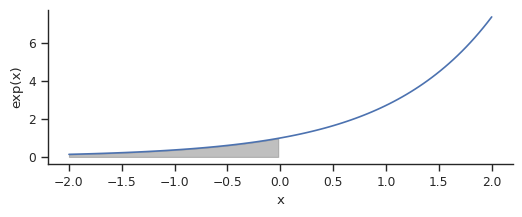

In [2]:
# plot exp of x from -5 to 5
plt.figure(figsize=(6, 2))
x = np.linspace(-2, 2, 100)
y = np.exp(x)
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('exp(x)')
# color with grey from -2 to 0
plt.fill_between(x, y, where=x < 0, color='grey', alpha=0.5)
sns.despine()
plt.show()

In [3]:
# unpockle IB_color_naming.pkl from data
with open('data/IB_color_naming.pkl', 'rb') as f:
    IB_color_naming = pickle.load(f)

# unpickle chip dict
with open('data/chip_dict.pkl', 'rb') as f:
    chip_dict = pickle.load(f)

# unpickle sielab_dict
with open('data/cielab_dict.pkl', 'rb') as f:
    cielab_dict = pickle.load(f)   

# unpickle rgb_dict
with open('data/rgb_dict.pkl', 'rb') as f:
    rgb_dict = pickle.load(f)

# unpickle languages
with open('data/lg_color.pkl', 'rb') as f:
    lg_color = pickle.load(f)

# unpickle lang_info
with open('data/lang_info.pkl', 'rb') as f:
    lang_info = pickle.load(f)

In [4]:
prior_m = IB_color_naming['pM']

# match index of prior_m to chip_dict coordinates 
# and build a new dict (coordinate: probability)
prior_m_ = []
for i, p in enumerate(prior_m):
    prior_m_.append((chip_dict[i+1], p))

# remove entries with first coordinate == 1
prior_m_ = [x for x in prior_m_ if x[0][1] != 0]

# use coordinate from prior_m_ to build a matrix with probabilities
prior_m_matrix = np.zeros((8, 40))
for c, p in prior_m_:
    prior_m_matrix[c[0]-1, c[1]-1] = p

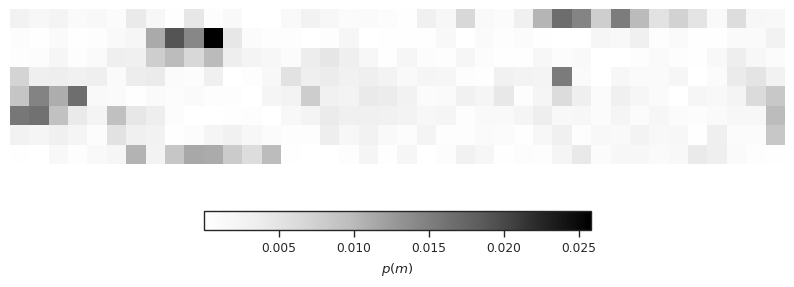

In [5]:
plt.figure(figsize=(10, 4))
plt.imshow(prior_m_matrix, cmap='Greys', interpolation='none')

# remove axes
plt.axis('off')

# Add colorbar at the bottom
cbar = plt.colorbar(orientation='horizontal', shrink=0.5)
cbar.set_label('$p(m)$')

plt.show()

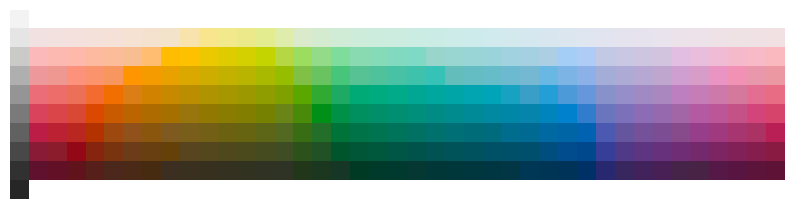

In [6]:
# Extract coordinates and colors from the dictionary
coordinates = list(rgb_dict.keys())
colors = [rgb_dict[coord] for coord in coordinates]

# Convert RGB values to valid color format understood by Matplotlib
colors = [(r, g, b) for r, g, b in colors]

grid_size = (max(coord[0] for coord in coordinates) + 1, 
             max(coord[1] for coord in coordinates) + 1)
image = np.zeros((grid_size[0], grid_size[1], 3))

# Assign colors to pixels
for coord, color in zip(coordinates, colors):
    image[coord[0], coord[1]] = color

# fill empty pixels with white
image[image.sum(axis=2) == 0] = (1, 1, 1)

plt.figure(figsize=(10, 4))
# Plot the image
plt.imshow(image, interpolation='none')
plt.axis('off')
# save to pdf
plt.savefig('figures/WCS.pdf', 
            bbox_inches='tight', 
            pad_inches=0)


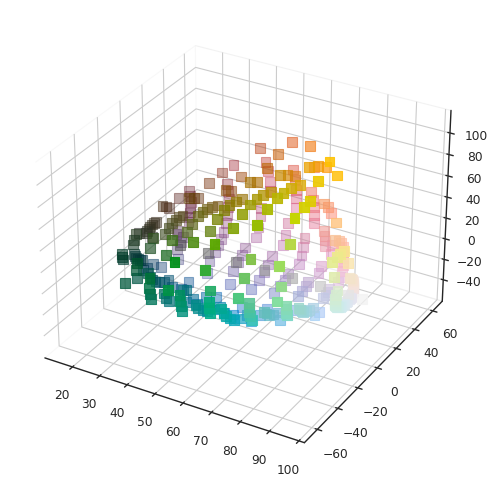

In [7]:
CIELAB_c = dict()

for coord in cielab_dict:
    CIELAB_c[cielab_dict[coord]] = image[coord[0]+1, coord[1]+1]


# plot CIELAB space as 3d scatter plot
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False


# Extract coordinates and colors from the dictionary
coordinates = list(CIELAB_c.keys())
colors = list(CIELAB_c.values())

# Convert RGB values to valid color format understood by Matplotlib
colors = [(r, g, b) for r, g, b in colors]

# Plot the points
ax.scatter(*zip(*coordinates), c=colors, s=50, marker='s')

# save to pdf
plt.savefig('figures/CIELAB.pdf', 
            bbox_inches='tight', 
            pad_inches=0)

plt.show()

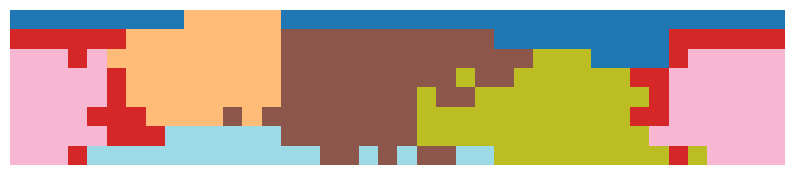

In [8]:
plt.figure(figsize=(10, 4))
plt.imshow(lg_color[11], cmap='tab20', interpolation='none')
plt.axis('off')
plt.savefig('figures/WCS_Bahinemo_c.png',
            bbox_inches='tight', 
            pad_inches=0)
plt.show()

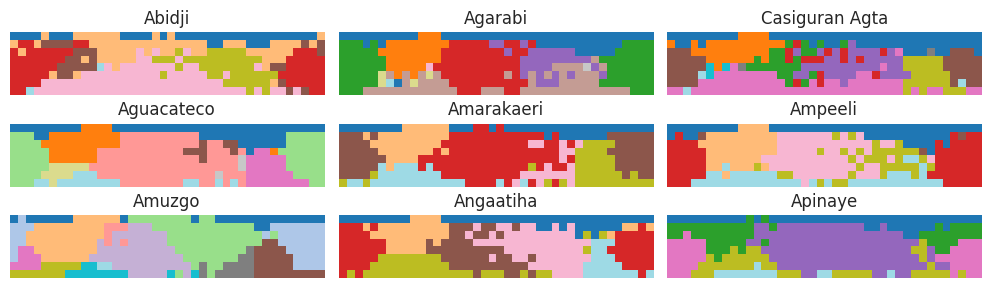

In [9]:
# plot a sample of 9 languages
plt.figure(figsize=(10, 3))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(lg_color[i+1], cmap='tab20', interpolation='none')
    plt.title(lang_info[i+1], fontsize=12)
    plt.axis('off')
plt.tight_layout()
plt.savefig('figures/WCS_sample.png', 
            bbox_inches='tight', 
            pad_inches=0)

In [10]:
# only choose coordinates in the range (0, 0), (8, 40)
cielab_dict_ = {k: v for k, v in cielab_dict.items() if k[0] in range(0, 9) and k[1] in range(0, 41)}

# reverse keys and values in cielab_dict_
cielab_dict_r = {v: k for k, v in cielab_dict_.items()}

# convert cielab_dict_ to a list of tuples ordered from (0, 0) to (8, 40)
cielab_list = [cielab_dict_[k] for k in sorted(cielab_dict_.keys())]

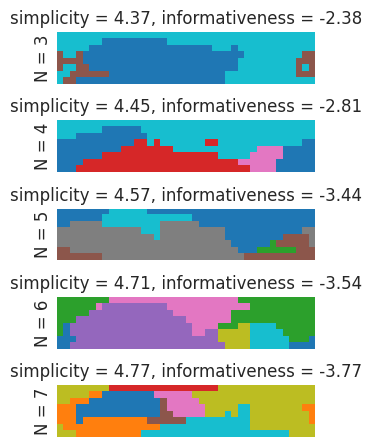

In [11]:
fig, ax = plt.subplots(5, 1)  # Adjust figure size if needed
k = 3

for j, conn in enumerate(range(3, 8)):
    a = ConvexCluster(X=np.zeros((8, 40)),
                      d=2,
                      N=k,
                      s=1,
                      c=0.001,
                      coords=cielab_list,
                      reverse_labels=cielab_dict_r)
    labels = a.run()
    ax[j].imshow(labels, cmap='tab10', interpolation='none')
    ax[j].set_xticks(range(labels.shape[1]))  # Explicitly set x ticks
    ax[j].set_yticks(range(labels.shape[0]))  # Explicitly set y ticks
    ax[j].set_title(f'simplicity = {compression(labels):.2f}, '
                    f'informativeness = {informativeness(labels, prior_m_matrix, cielab_dict):.2f}', fontsize=12)
    # remove axes
    # ax[j].axis('off')
    # remove ticks
    ax[j].set_xticks([])
    ax[j].set_yticks([])
    # remove borders
    ax[j].spines['top'].set_visible(False)
    ax[j].spines['right'].set_visible(False)
    ax[j].spines['bottom'].set_visible(False)
    ax[j].spines['left'].set_visible(False)
    k += 1

# set y ticks to "N = {k}" for each subplot
for i, ax in enumerate(ax):
    ax.set_ylabel(f'N = {i+3}', fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make space for x-axis labels
# save to png
plt.savefig('figures/convexity.png',
            bbox_inches='tight',
            pad_inches=0)
plt.show()

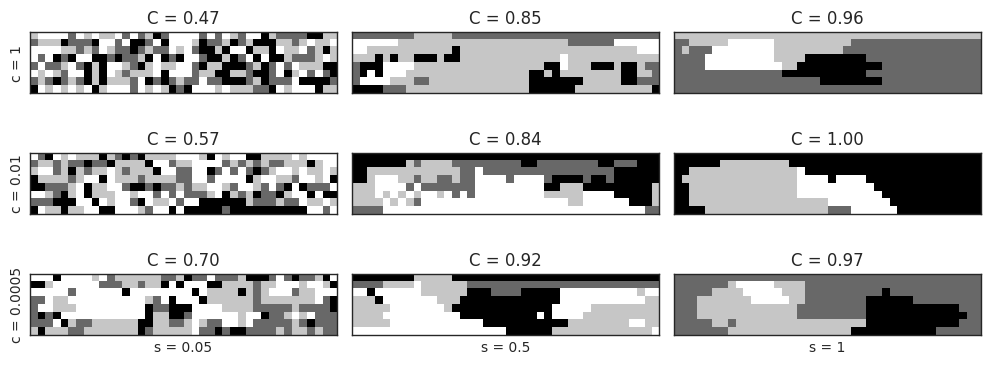

In [12]:
# plot 4 x 4 possible color clusters with parameter smooth in [0.1, 0.25, 0.5, 1] and conn in [0.1, 0.25, 0.5, 1]
fig, ax = plt.subplots(3, 3, figsize=(10, 4))

smooth_values = [0.05, 0.5, 1]
conn_values = [0.0005, 0.01, 1]
conn_values = [_ for _ in reversed(conn_values)]

for i, smooth in enumerate(smooth_values):
    for j, conn in enumerate(conn_values):
        a = ConvexCluster(X = np.zeros((8, 40)), 
                         d = 2, 
                         N = 4, 
                         s = smooth, 
                         c = conn,
                         coords=cielab_list,
                         reverse_labels=cielab_dict_r)
        labels = a.run()
        ax[i, j].imshow(labels, 
                        cmap='Greys_r', 
                        interpolation='none')
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        ax[i, j].set_title(f'C = {a.degree_of_convexity():.2f}', fontsize=12)
        # remove border
        # for spine in ax[i, j].spines.values():
        #     spine.set_visible(False)
        # ax[i, j].set_title(f'MDL = {mdl(labels):.2f}')
        
# Label the conn values on the y-axis
for i, conn in enumerate(conn_values):
    ax[i, 0].set_ylabel('c = ' + str(conn), fontsize=10)

# Label the smooth values on the x-axis
for j, smooth in enumerate(smooth_values):
    ax[2, j].set_xlabel('s = ' + str(smooth), fontsize=10)

plt.tight_layout()
# save the plot as pdf
plt.savefig('figures/convex_clusters.png', 
            bbox_inches='tight', 
            pad_inches=0)
plt.show()

In [13]:
def generate_grid(n, n_low, n_high, d = 2, X = 10, Y = 10):
    s_values = np.random.uniform(0, 1, n)
    c_values = np.random.uniform(0, 1, n)

    mdl_values = []
    conv_values = []
    cost_values = []
    categ = []
    param_dict = {}
    lgs = []

    for i, sc in tqdm(enumerate(zip(s_values, c_values)), total=n, desc='Generating Grid'):
        N = np.round(np.random.uniform(n_low, n_high), 0).astype(int)
        a = ConvexCluster(X = np.zeros((X, Y)), 
                        d = d, 
                        N = N,
                        s = sc[0], 
                        c = sc[1],
                        coords=cielab_list,
                        reverse_labels=cielab_dict_r)
        l = a.run()
        
        lgs.append(l)
        param_dict[i] = (sc[0], sc[1], N)
        mdl_values.append(compression(l))
        conv_values.append(a.degree_of_convexity())
        cost_values.append(informativeness(l, 
                                           prior_m_matrix, 
                                           cielab_dict))
        categ.append(N)
    
    return mdl_values, conv_values, cost_values, categ, param_dict, lgs

In [14]:
# results = generate_grid(n = 60000, 
#                         d = 2, 
#                         X = 8,
#                         Y = 40,
#                         n_low = 3,
#                         n_high = 15)

In [15]:
# dump results to pickle
# with open('data/convex_cluster_results.pkl', 'wb') as f:
#     pickle.dump(results, f)

# import results from pickle
with open('data/convex_cluster_results.pkl', 'rb') as f:
    results = pickle.load(f)

In [16]:
mdl_values, conv_values, cost_values, categ, param_dict, lgs = results

In [20]:
with open('data/lgs-convexity-categories.pkl', 'wb') as f:
    pickle.dump([lgs, conv_values, categ], f)

In [21]:
# pickle lgs
with open('data/lgs.pkl', 'wb') as f:
    pickle.dump(lgs, f)

In [22]:
# recompute mdl_values
mdl_values = [compression(l) for l in lgs]

In [23]:
# iterate over cost_values, if a value is inf, then remove it from the list and from the other lists
for i, val in enumerate(cost_values):
    if np.isinf(val):
        mdl_values.pop(i)
        conv_values.pop(i)
        categ.pop(i)
        cost_values.pop(i)

In [24]:
pareto_front_indices = non_dominated_front(mdl_values, cost_values)
pareto_front_points = [(mdl_values[i], cost_values[i]) for i in pareto_front_indices]

# find duplicates in either x or y and remove them
pareto_front_points = list(set(pareto_front_points))

x_pareto, y_pareto = zip(*pareto_front_points)

In [25]:
# create a smooth line over x_pareto and y_pareto using lowess
lowess = sm.nonparametric.lowess
smoothed = lowess(y_pareto, x_pareto)

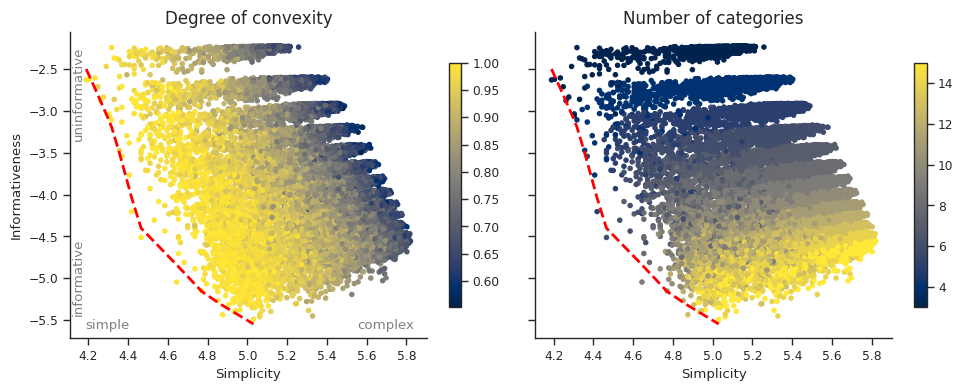

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), 
                               sharey=True)
sns.despine(top=True, right=True)
# Plot with convexity
scatter1 = ax1.scatter(mdl_values, cost_values, 
                       c=conv_values, cmap='cividis', alpha=1,
                       s = 10, marker = 'o')
ax1.plot(smoothed[:, 0], smoothed[:, 1], 
         color = 'red', alpha=1,  
         linewidth=2, linestyle='--')
scatter1.set_rasterized(True)
ax1.text(-1.28, 0.2, 'informative', ha='center',
         va='center', transform=ax2.transAxes,
         color = 'grey', rotation = 90)
ax1.text(-1.28, 0.8, 'uninformative', ha='center',
         va='center', transform=ax2.transAxes,
         color = 'grey', rotation = 90)
ax1.text(-1.2, 0.04, 'simple', ha='center', 
         va='center', transform=ax2.transAxes,
         color = 'grey')
ax1.text(-0.42, 0.04, 'complex', ha='center', 
         va='center', transform=ax2.transAxes,
         color = 'grey')
ax1.set_xlabel('Simplicity')
ax1.set_ylabel('Informativeness')
ax1.set_title('Degree of convexity', fontsize=12)
cbar1 = fig.colorbar(scatter1, ax=ax1, shrink=0.8)
# Plot with number of categories
scatter2 = ax2.scatter(mdl_values, cost_values, c=categ, 
                       cmap='cividis', alpha=1,
                       s = 10, marker = 'o')
ax2.plot(smoothed[:, 0], smoothed[:, 1], 
         color = 'red', alpha=1, 
         linewidth=2, linestyle='--')
# ax2.scatter(*zip(*pareto_front_points), c='red', marker='x', s=20)
scatter2.set_rasterized(True)
ax2.set_xlabel('Simplicity')
ax2.set_title('Number of categories', fontsize=12)
# ax2.grid(linestyle='--', alpha=0.5)
cbar2 = fig.colorbar(scatter2, ax=ax2, shrink=0.8)

plt.tight_layout()

# save the plot as pdf
plt.savefig('figures/convexity_categories_blank.png', dpi=300)
plt.show()

In [27]:
# for each point in (mdl_values, cost_values), calculate the distance to the points in the pareto front
distances = []

x_pareto = np.array(x_pareto)
y_pareto = np.array(y_pareto)

for i, j in zip(mdl_values, cost_values):
    distances.append(np.min(np.sqrt((i - x_pareto)**2 + (j - y_pareto)**2)))

In [28]:
df = pd.DataFrame({'convexity': conv_values,
                   'categories': categ,
                   'distance': distances,
                   'simplicity': mdl_values})

In [29]:
# standardize categories and convexity
df['categories_z'] = (df['categories'] - df['categories'].mean()) / df['categories'].std()
df['convexity_z'] = (df['convexity'] - df['convexity'].mean()) / df['convexity'].std()
df['simplicity_z'] = (df['simplicity'] - df['simplicity'].mean()) / df['simplicity'].std()

In [30]:
# statsmodels regression predicting distance from convexity and number of categories

# remove nan or inf
df = df.replace([np.inf, -np.inf], np.nan).dropna()

X = df[['convexity_z', 'categories_z']] # 'categories_z',
y = df['distance']

X = sm.add_constant(X)

# formula 
formula = 'distance ~ convexity_z + categories_z + convexity_z*categories_z'
model_art = sm.OLS.from_formula(formula, data=df).fit()


# model_art = sm.OLS(y, X).fit()

# summarize our model
model_art.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               distance   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                 4.369e+04
Date:                Mon, 29 Apr 2024   Prob (F-statistic):               0.00
Time:                        16:30:53   Log-Likelihood:                 25735.
No. Observations:               30000   AIC:                        -5.146e+04
Df Residuals:                   29996   BIC:                        -5.143e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    1.0008      0.001   1654.039      0.000       1.000       1.002
convexity_z                 -0.2156      0.001   -356.238      0.000      -0.217      -0.214
categories_z                 0.0790      0.001    130.390      0.000       0.078       0.080
convexity_z:categories_z    -0.0266      0.001    -43.003      0.000      -0.028      -0.025
==============================================================================
Omnibus:                     3347.201   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6860.278
Skew:                          -0.711   Prob(JB):                         0.00
Kurtosis:                       4.861   Cond. No.                         1.27
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

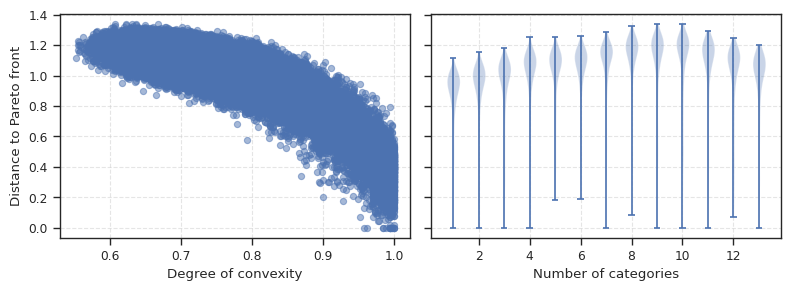

In [31]:
# Create a scatter plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), sharey=True)

# Plot convexity vs distance
ax1.set_axisbelow(True)
ax1.grid(linestyle='--', alpha=0.5)
s = ax1.scatter(df['convexity'], df['distance'], alpha=0.5, s=20)
s.set_rasterized(True)
ax1.set_xlabel('Degree of convexity')
ax1.set_ylabel('Distance to Pareto front')

# Plot categories vs distance
# ax2.scatter(df['categories'], df['distance'], alpha=0.5, s=20)
ax2.set_axisbelow(True)
ax2.grid(linestyle='--', alpha=0.5)
ax2.violinplot(df.groupby('categories')['distance'].apply(list).to_list(), vert=True)
ax2.set_xlabel('Number of categories')

plt.tight_layout()
# save to pdf
plt.savefig('figures/convexity_categories_distance.pdf', dpi=300)
plt.show()

In [32]:
# enumerate over grids in lg_color and calculate informativeness
informativeness_values = []
simplicity_values = []
categ_values = []
lg_ids = list(lg_color.keys())

for grid in lg_color:
    informativeness_values.append(informativeness(lg_color[grid], prior_m_matrix, cielab_dict))
    simplicity_values.append(compression(lg_color[grid]))
    categ_values.append(len(np.unique(lg_color[grid])))

In [33]:
# count the number of unique values in each grid in lg_color
unique_values = [len(np.unique(lg_color[grid])) for grid in lg_color]
# print min and max
print(min(unique_values), max(unique_values))

3 15


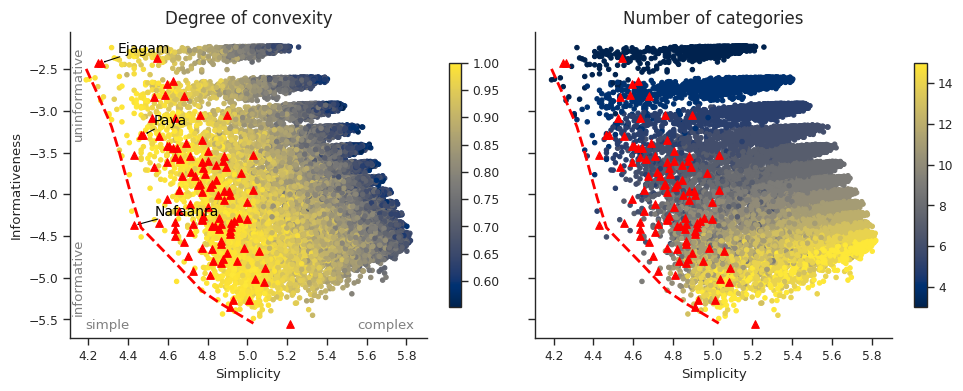

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), 
                               sharey=True)
sns.despine(top=True, right=True)
# Plot with convexity
scatter1 = ax1.scatter(mdl_values, cost_values, 
                       c=conv_values, cmap='cividis', alpha=1,
                       s = 10, marker = 'o')
ax1.plot(smoothed[:, 0], smoothed[:, 1], 
         color = 'red', alpha=1,  
         linewidth=2, linestyle='--')
ax1.scatter(simplicity_values, informativeness_values, 
            c='red', marker='^', s=30)
# add labels to 2 points with minimum simplicity from lang_info
texts = []
for lg in [32, 72, 76]:
    text = ax1.text(simplicity_values[lg], informativeness_values[lg], 
                    lang_info[lg_ids[lg]], fontsize=10, color='black')
    texts.append(text)
# Use adjust_text to add repulsion
adjust_text(texts, arrowprops=dict(arrowstyle='->',
                                    color='black'), 
                                    ax=ax1, expand=(2, 2))
scatter1.set_rasterized(True)
ax1.text(-1.28, 0.2, 'informative', ha='center',
         va='center', transform=ax2.transAxes,
         color = 'grey', rotation = 90)
ax1.text(-1.28, 0.8, 'uninformative', ha='center',
         va='center', transform=ax2.transAxes,
         color = 'grey', rotation = 90)
ax1.text(-1.2, 0.04, 'simple', ha='center', 
         va='center', transform=ax2.transAxes,
         color = 'grey')
ax1.text(-0.42, 0.04, 'complex', ha='center', 
         va='center', transform=ax2.transAxes,
         color = 'grey')
ax1.set_xlabel('Simplicity')
ax1.set_ylabel('Informativeness')
ax1.set_title('Degree of convexity', fontsize=12)
cbar1 = fig.colorbar(scatter1, ax=ax1, shrink=0.8)

# Plot with number of categories
scatter2 = ax2.scatter(mdl_values, cost_values, c=categ, 
                       cmap='cividis', alpha=1,
                       s = 10, marker = 'o')
scatter2.set_rasterized(True)
ax2.plot(smoothed[:, 0], smoothed[:, 1], 
         color = 'red', alpha=1, 
         linewidth=2, linestyle='--')
ax2.scatter(simplicity_values, informativeness_values, c='red', marker='^', s=30)
# ax2.scatter(*zip(*pareto_front_points), c='red', marker='x', s=20)
scatter2.set_rasterized(True)
ax2.set_xlabel('Simplicity')
ax2.set_title('Number of categories', fontsize=12)
# ax2.grid(linestyle='--', alpha=0.5)
cbar2 = fig.colorbar(scatter2, ax=ax2, shrink=0.8)

plt.tight_layout()

# save the plot as pdf
plt.savefig('figures/convexity_categories.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [38]:
# correlation between informativeness and simplicity (Kendall's tau)
tau, p_value = stats.kendalltau(mdl_values, cost_values)
print(f'Kendall\'s tau: {tau:.2f}, p-value: {p_value:.2f}')

Kendall's tau: -0.39, p-value: 0.00


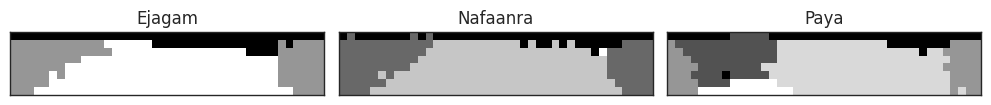

In [30]:
# plot color systems [32, 72]
fig, ax = plt.subplots(1, 3, figsize=(10, 4))
for i, lg in enumerate([32, 72, 76]):
    ax[i].imshow(lg_color[lg_ids[lg]], cmap='Greys_r', interpolation='none')
    ax[i].set_title(lang_info[lg_ids[lg]], fontsize=12)
    # ax[i].axis('off')
    # on;ly remove ticks
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()

In [31]:
# measure the degree of convexity for each grid in lg_color
convexity_values = [degree_of_convexity(np.expand_dims(lg_color[grid], axis=0))[0] for grid in lg_color]
# compute the number of categories for each grid in lg_color
categories_values = [len(np.unique(lg_color[grid])) for grid in lg_color]
# compute the distance to the pareto front for each grid in lg_color
distances_values = [np.min(np.sqrt((simplicity_values[i] - x_pareto)**2 + 
                                   (informativeness_values[i] - y_pareto)**2)) for i in range(len(simplicity_values))]

# standardize the values
simplicity_values_z = (simplicity_values - np.mean(simplicity_values)) / np.std(simplicity_values)
informativeness_values_z = (informativeness_values - np.mean(informativeness_values)) / np.std(informativeness_values)
convexity_values_z = (convexity_values - np.mean(convexity_values)) / np.std(convexity_values)
categ_values_z = (categories_values - np.mean(categories_values)) / np.std(categories_values)

# create a dataframe
df_lg = pd.DataFrame({'convexity': convexity_values,
                      'categories': categories_values,
                      'convexity_z': convexity_values_z,
                      'categories_z': categ_values_z,
                      'distance': distances_values,
                      'simplicity_z': simplicity_values,
                      'informativeness_z': informativeness_values_z})

In [32]:
# run a linear regression
X = df_lg[['convexity_z', 'categories_z']]
y = df_lg['distance']
X = sm.add_constant(X)

# formula
formula = 'distance ~ convexity_z + categories_z + convexity_z*categories_z'
model_lg = sm.OLS.from_formula(formula, data=df_lg).fit()

# summarize our model
model_lg.summary()

# model = sm.OLS(y, X).fit()
# model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               distance   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     4.337
Date:                Wed, 24 Apr 2024   Prob (F-statistic):            0.00647
Time:                        17:15:18   Log-Likelihood:                 72.717
No. Observations:                 103   AIC:                            -137.4
Df Residuals:                      99   BIC:                            -126.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.3832      0.014     27.379      0.000       0.355       0.411
convexity_z                 -0.0094      0.018     -0.533      0.595      -0.044       0.026
categories_z                 0.0145      0.018      0.825      0.411      -0.020       0.049
convexity_z:categories_z     0.0357      0.010      3.588      0.001       0.016       0.055
==============================================================================
Omnibus:                        0.944   Durbin-Watson:                   2.098
Prob(Omnibus):                  0.624   Jarque-Bera (JB):                1.004
Skew:                           0.131   Prob(JB):                        0.605
Kurtosis:                       2.593   Cond. No.                         3.23
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
coefficients_art = model_art.params
coefficients_art = coefficients_art[1:]
# get 95% confidence intervals
ci_art = model_art.conf_int(alpha=0.05, cols=None)

coefficients = model_lg.params
coefficients = coefficients[1:]
# get 95% confidence intervals
ci = model_lg.conf_int(alpha=0.05, cols=None)

# compute yerr
yerr = (ci[1] - ci[0]) / 3
yerr = yerr[1:]
yerr_art = (ci_art[1] - ci_art[0]) / 3
yerr_art = yerr_art[1:]

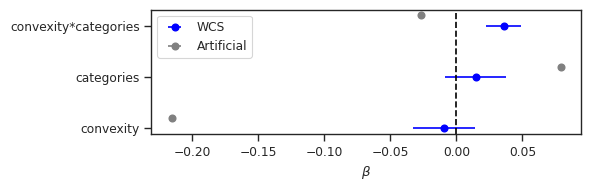

In [34]:
# plot coefficients and confidence intervals on the same plot with different colors for each model
fig, ax = plt.subplots(1, 1, figsize=(6, 2))
ax.errorbar(coefficients, range(len(coefficients)), xerr=yerr, fmt='o', 
            label='WCS', color='blue')
ax.errorbar(coefficients_art, [i + 0.2 for i in range(len(coefficients))], xerr=yerr_art, 
            fmt='o', label='Artificial', color='grey')
# add line at 0
# add text ticks saying 'categories' and 'convexity'
ax.set_yticks(range(len(coefficients)))
ax.set_yticklabels(['convexity', 'categories', 'convexity*categories'])
ax.axvline(0, color='black', linestyle='--')
ax.set_xlabel('$\\beta$')
ax.legend()
plt.tight_layout()
# save to png
plt.savefig('figures/coefficients.png', dpi=300)
plt.show()

In [35]:
# # Create a scatter plot with four subplots
# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 4))

# # Plot convexity vs distance (subplot 1)
# ax1.set_axisbelow(True)
# ax1.grid(linestyle='--', alpha=0.5)
# s1 = ax1.scatter(df['convexity'], df['distance'], alpha=0.5, s=20)
# s1.set_rasterized(True)
# ax1.set_xlabel('Degree of convexity')
# ax1.set_ylabel('Distance to Pareto front')

# # Plot categories vs distance (subplot 2)
# ax2.set_axisbelow(True)
# ax2.grid(linestyle='--', alpha=0.5)
# ax2.violinplot(df.groupby('categories')['distance'].apply(list).to_list(), vert=True)
# ax2.set_xlabel('Number of categories')

# # Plot convexity vs distance (subplot 3)
# ax3.set_axisbelow(True)
# ax3.grid(linestyle='--', alpha=0.5)
# s2 = ax3.scatter(df_lg['convexity'], df_lg['distance'], alpha=0.5, s=20)
# s2.set_rasterized(True)
# ax3.set_xlabel('Degree of convexity')
# ax3.set_ylabel('Distance to Pareto front')
# ax3.set_xlim(ax1.get_xlim())
# ax3.set_ylim(ax1.get_ylim())

# # Plot categories vs distance (subplot 4)
# ax4.set_axisbelow(True)
# ax4.grid(linestyle='--', alpha=0.5)
# ax4.violinplot(df_lg.groupby('categories')['distance'].apply(list).to_list(), vert=True)
# ax4.set_xlabel('Number of categories')

# plt.tight_layout()
# # save to pdf
# plt.savefig('figures/combined_plot.pdf', dpi=300)
# plt.show()

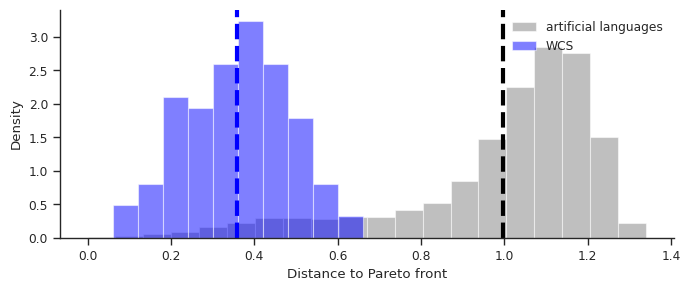

In [36]:
plt.figure(figsize=(7, 3))
plt.hist(df['distance'], color='grey', 
         alpha=0.5, label='artificial languages', density=True, bins=20)
# add mean lines
plt.axvline(df['distance'].mean(), color='black', linestyle='--', linewidth=3)
plt.hist(df_lg['distance'], color='blue', 
         alpha=0.5, label='WCS', density=True, bins=10)
# add mean lines
plt.axvline(df_lg['distance'].mean(), color='blue', linestyle='--', linewidth=3)
plt.legend(frameon=False, loc='upper right')
plt.xlabel('Distance to Pareto front')
plt.ylabel('Density')
sns.despine()
plt.tight_layout()
# save to png
plt.savefig('figures/distance_hist.png', dpi=300, bbox_inches='tight')
plt.show()

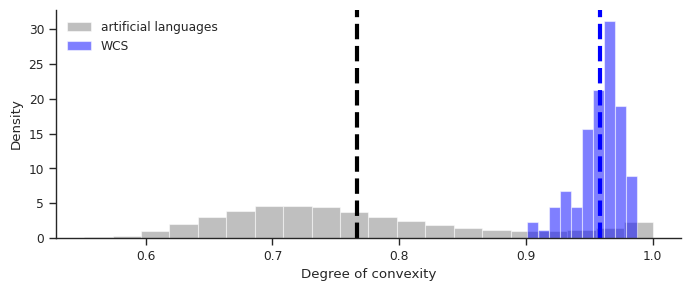

In [37]:
# plot distribution of degrees of convexity for artificial languages and WCS
plt.figure(figsize=(7, 3))
plt.hist(df['convexity'], color='grey', alpha=0.5, label='artificial languages', density=True, bins=20)
# add mean lines
plt.axvline(df['convexity'].mean(), color='black', linestyle='--', linewidth=3)
plt.hist(df_lg['convexity'], color='blue', alpha=0.5, label='WCS', density=True, bins=10)
# add mean lines
plt.axvline(df_lg['convexity'].mean(), color='blue', linestyle='--', linewidth=3)
plt.legend(frameon=False, loc='upper left')
plt.xlabel('Degree of convexity')
plt.ylabel('Density')
sns.despine()
plt.tight_layout()
# save to png
plt.savefig('figures/convexity_hist.png', dpi=300, bbox_inches='tight')
plt.show()

In [38]:
def plot_n_neighbours(idx_list, n):
    k = len(idx_list)  # Number of indices in the list
    fig, ax = plt.subplots(n, k, figsize=(8, 3))  # Adjust figsize as needed

    for col, idx in enumerate(idx_list):
        distances = []
        comp = compression(lg_color[idx])
        info = informativeness(lg_color[idx], prior_m_matrix, cielab_dict)

        for i, j in zip(mdl_values, cost_values):
            distances.append(np.sqrt((i - comp)**2 + (j - info)**2))

        # Sort distances (from smallest to largest) and get the indices
        nearest_indices = np.argsort(distances)[:n]

        for row, nearest_idx in enumerate(nearest_indices):
            if row == 0:
                ax[row, col].set_title(lang_info[idx], fontsize=12)
                ax[row, col].imshow(lg_color[idx], cmap='tab10', interpolation='none')
            else:
                ax[row, col].set_title(f'{row}-st nearest', fontstyle='italic')
                ax[row, col].imshow(lgs[nearest_idx], cmap='tab10', interpolation='none')
            ax[row, col].set_xticks([])
            ax[row, col].set_yticks([])
            # remove border
            for spine in ax[row, col].spines.values():
                spine.set_visible(False)

    # plt.tight_layout()
    plt.savefig('figures/nearest_neighbours.png', dpi=300, bbox_inches='tight')
    plt.show()


In [40]:
# random_indexes

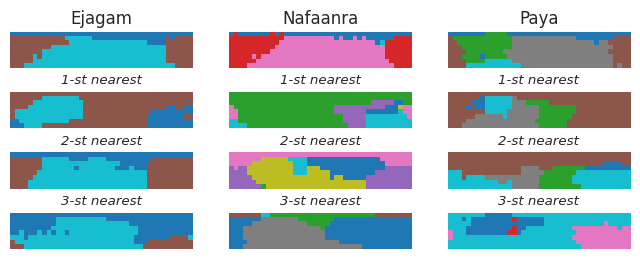

In [41]:
# Sample 3 random indexes
lg_index = [lg_ids[_] for _ in [32, 72, 76]]

# Plot nearest neighbors
plot_n_neighbours(lg_index, 4)